<a href="https://colab.research.google.com/github/MahdiEsrafili/image_segmentation/blob/master/face_seg_CelebAHQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# !gdown --id 1badu11NqxGf6qM3PTTooQDJvQbejgbTv
!cp drive/MyDrive/CelebAMask-HQ.zip ./

In [10]:
!unzip -q CelebAMask-HQ.zip -d data/

In [11]:
!git clone https://github.com/MahdiEsrafili/SegLoss.git

Cloning into 'SegLoss'...
remote: Enumerating objects: 334, done.
remote: Total 334 (delta 0), reused 0 (delta 0), pack-reused 334
Receiving objects: 100% (334/334), 371.26 KiB | 23.20 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
from PIL import Image
import re
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from SegLoss.losses_pytorch import lovasz_loss
from tqdm.notebook import tqdm

In [13]:
atts = ['skin', 'l_brow', 'r_brow', 'l_eye', 'r_eye', 'eye_g', 'l_ear', 'r_ear', 'ear_r',
            'nose', 'mouth', 'u_lip', 'l_lip', 'neck', 'neck_l', 'cloth', 'hair', 'hat']

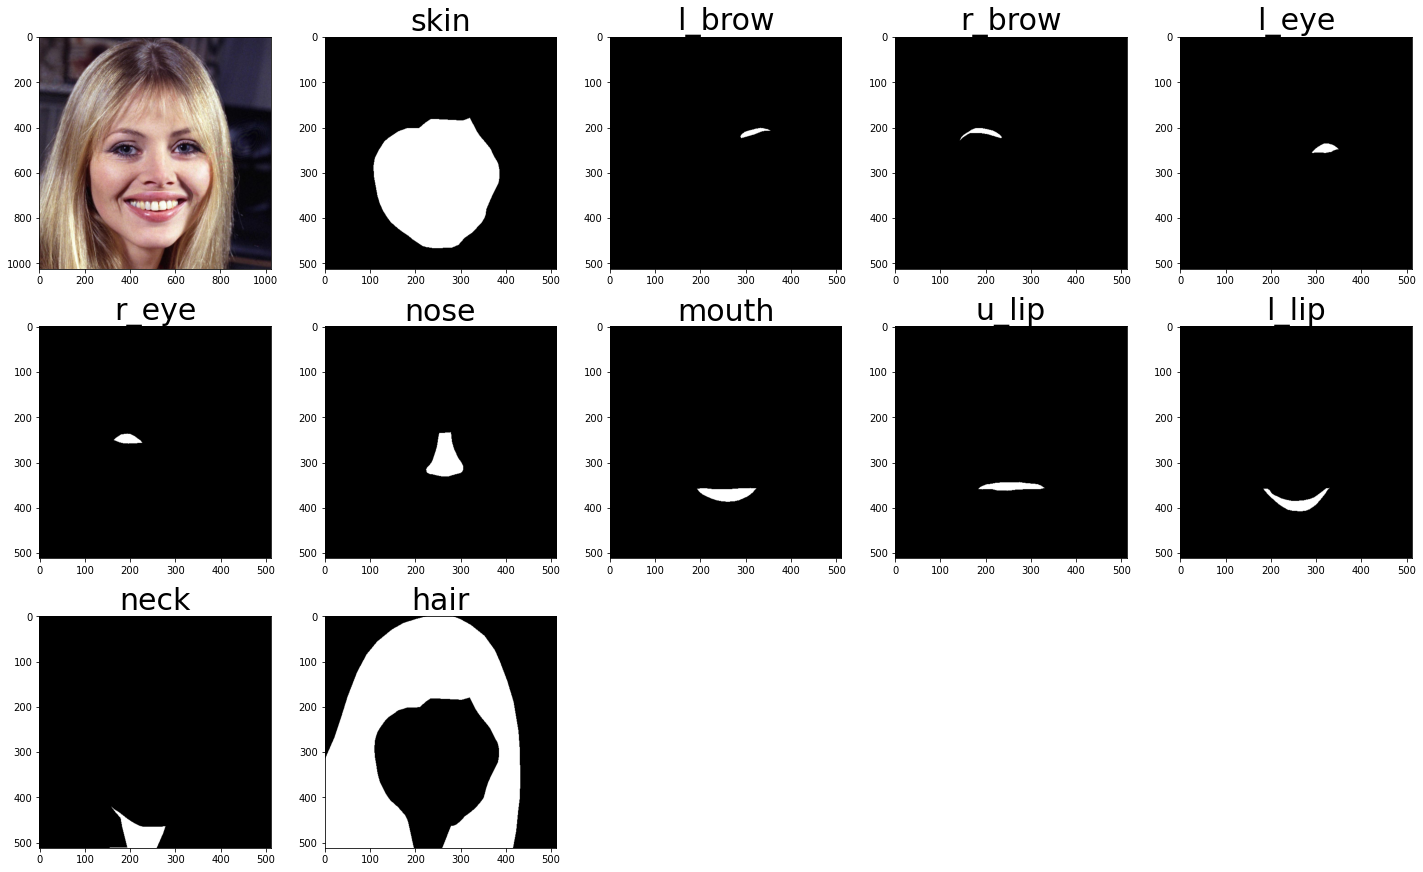

In [18]:
path_anno = '/content/data/CelebAMask-HQ/CelebAMask-HQ-mask-anno'
path_img = '/content/data/CelebAMask-HQ/CelebA-HQ-img'
id = 780
plt.figure(figsize=(20, 16))
plt.subplot(4,5,1)
img = Image.open(os.path.join(path_img, f'{id}.jpg'))
plt.imshow(img)
i = 2
m = list()
for a in atts:
  try:
    m.append(Image.open(os.path.join(path_anno, '0', f'{id:05}_{a}.png')))
    plt.subplot(4,5,i)
    plt.imshow(m[-1])
    plt.title(a, fontsize=30)
    i += 1
  except:
    pass
   



plt.tight_layout()

In [33]:
m0 = np.array(m[0])
r = m0 * np.logical_xor(m0, np.array(m[5]))

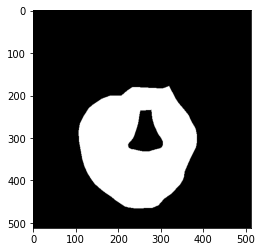

In [34]:
plt.imshow(r)

In [16]:
locs = dict()
for i in range(15):
  files = os.listdir(os.path.join(path_anno, str(i)))
  for f in files:
    if '.DS' in f:
      continue
    id, attr = f.split('_', maxsplit=1)
    id = int(id)
    if id in locs:
      locs[id]['attrs'].append(attr.split('.')[0])
    else:
      locs[id] = {'dir':i, 'attrs':[attr.split('.')[0]]}


<BarContainer object of 18 artists>

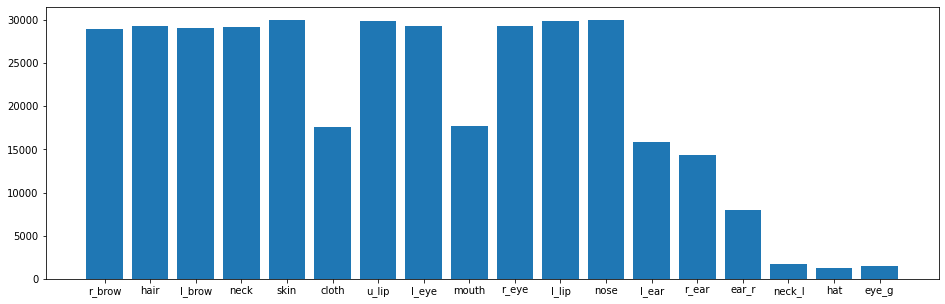

In [17]:
attr_count = dict()
for k, v in locs.items():
  for a in v['attrs']:
    if a in attr_count:
      attr_count[a] += 1
    else:
      attr_count[a] = 1
plt.figure(figsize=(16, 5))
plt.bar(attr_count.keys(), attr_count.values())

In [41]:
class CelebDS(Dataset):
  def __init__(self, img_path, annot_path, locs, transforms=None):
    self.img_path = img_path
    self.annot_path = annot_path
    self.locs = locs
    self.transforms = transforms
    self.attrs = {'skin':1, 'l_brow':2, 'r_brow':3, 'l_eye':4, 'r_eye':5,
                  'eye_g':6, 'l_ear':7, 'r_ear':8, 'ear_r':9,
                  'nose':10, 'mouth':11, 'u_lip':12, 'l_lip':13,
                  'neck':14, 'neck_l':15, 'cloth':16, 'hair':17, 'hat':18}

  def __len__(self):
    return len(self.locs)

  def __getitem__(self, id):
    img = Image.open(os.path.join(self.img_path, f'{id}.jpg'))
    annot_subdir = self.locs[id]['dir']
    celeb_attrs = self.locs[id]['attrs']
    mask = np.zeros((512, 512))
    for attr in celeb_attrs:
      attr_path = os.path.join(self.annot_path, str(annot_subdir), f'{id:05}_{attr}.png')
      annot = Image.open(attr_path)
      annot = (np.array(annot)[:,:,0])//255
      if attr == 'skin':
        skin = annot
        continue
      mask += annot*self.attrs[attr]
    mask += (skin * np.logical_xor(mask, skin)) * self.attrs['skin']
    mask = torch.tensor(mask)
    img = self.transforms(img)
    return img, mask

In [42]:
transforms = T.Compose([T.Resize((512, 512)), T.ToTensor()])

In [43]:
celeb_ds = CelebDS(path_img, path_anno, locs, transforms=transforms)

In [63]:
train_dataset, test_dataset = torch.utils.data.random_split(celeb_ds, [5000, 25000])
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader =  DataLoader(test_dataset, batch_size=batch_size)

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [65]:
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True)
model.classifier = torchvision.models.segmentation.deeplabv3.DeepLabHead(2048, 19)
model = model.train().to(device)

In [66]:
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# criterion = torch.nn.CrossEntropyLoss()
criterion = lovasz_loss.LovaszSoftmax()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

In [67]:
dataloaders = {'train': train_loader,
               'test': test_loader}

In [68]:
def train(model, optimizer, criterion, lr_scheduler, dataloaders, num_epochs=10):
  model.train()
  loss_history = list()
  for epoch in range(num_epochs):
    pbar = tqdm(dataloaders['train'])
    epoch_losses = np.array([])
    for (images, masks) in pbar:
      images = images.to(device, dtype=torch.float)
      masks = masks.to(device, dtype=torch.long)
      optimizer.zero_grad()
      out = model(images)
      loss = criterion(out['out'], masks)
      loss.backward()
      optimizer.step()
      epoch_losses = np.append(epoch_losses, loss.item())
      pbar.set_description(f'epoch {epoch+1}/{num_epochs},\
                            loss= {epoch_losses.mean():.4f}')
    loss_history.append(epoch_losses.mean())
    lr_scheduler.step()
  return loss_history
      

In [69]:
loss_history = train(model, optimizer, criterion, lr_scheduler, dataloaders, num_epochs=10)

KeyboardInterrupt: ignored

In [70]:
test_img, test_mask = test_dataset[0]

In [71]:
with torch.no_grad():
  model.eval()
  pred = model(test_img.unsqueeze(0).to(device))

In [73]:
pred.keys()

odict_keys(['out', 'aux'])

In [75]:
pred['out'].shape

torch.Size([1, 19, 512, 512])

In [77]:
pred0 = pred['out'].squeeze()
pred0.shape


torch.Size([19, 512, 512])

In [79]:
pred0 = pred0.permute(1,2,0).cpu().numpy()

In [81]:
pred0a = pred0.argmax(axis=2)

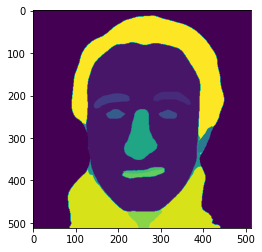

In [83]:
plt.imshow(pred0a)

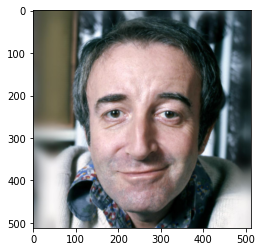

In [84]:
plt.imshow(test_img.permute(1,2,0))

In [87]:
torch.save(model, 'face_segment_celeb.pt')

In [88]:
!cp face_segment_celeb.pt drive/MyDrive/face_segment/